In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200 #allows to desplay the entire strings in the dataframe

# Load Data

In [3]:
# Folder
PATH_FOLDER = 'wikispeedia_paths-and-graph/'

# Defining paths
ARTICLES_DATA = PATH_FOLDER + "articles.tsv"
CATEGORIES_DATA = PATH_FOLDER + "categories.tsv"
LINKS_DATA = PATH_FOLDER + "links.tsv"
PATH_FINISHED_DATA = PATH_FOLDER + "paths_finished.tsv"
PATH_UNFINISHED_DATA = PATH_FOLDER + "paths_unfinished.tsv"
SHORTESTPATH_DATA = PATH_FOLDER + "shortest-path-distance-matrix.txt"

# Loading all data series
articles = pd.read_csv(ARTICLES_DATA, header=None, names=['article'], comment='#')
categories = pd.read_csv(CATEGORIES_DATA, sep='\t', header=None, names=['article', 'category'], comment='#')
links = pd.read_csv(LINKS_DATA, sep='\t', header=None, names=["linkSource", 'linkTarget'], comment='#')
path_finished = pd.read_csv(PATH_FINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'], comment='#')
path_unfinished = pd.read_csv(PATH_UNFINISHED_DATA, sep='\t', header=None, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'], comment='#')
shortest_path = pd.read_csv(SHORTESTPATH_DATA, sep='\t', header=None, names=['shortestPath'], comment='#')


# Graph analysis to compute centrality

In [4]:
def check_character(headline, character):
    '''Inputs:
            headline: string
            list_words: string
        Return:
            1 if the character is in the headline
            0 otherwise
    '''
    if character in headline: #
        return 1 
    else:
         return 0

In [5]:
path_finished['back'] = path_finished['path'].apply(lambda x : check_character(x, '<'))
path_finished_filtered = path_finished[path_finished['back']==0]

## Creation of the graph

In [6]:
def Convert(string):
    li = list(string.split(";"))
    return li

In [7]:
path_finished_filtered['path'] = path_finished_filtered['path'].apply(lambda x : Convert(x))


<ipython-input-7-da8c3ace79c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  path_finished_filtered['path'] = path_finished_filtered['path'].apply(lambda x : Convert(x))


In [8]:
import networkx as nx

In [9]:
edges = []
for index, row in path_finished_filtered.iterrows(): 
    edges.extend(list(zip(row['path'][0:-2],row['path'][1:-1])))

edges_wo_duplicates = [] #enleve duplicates des tuples
for tup in edges:
    if tup not in edges_wo_duplicates:
        edges_wo_duplicates.append(tup)

In [10]:
#compute weight by counting occurences of tuples in list
import collections
count = collections.defaultdict(int)
for elem in edges:
    count[elem] += 1

In [11]:
G = nx.DiGraph()
for t in edges_wo_duplicates:
    G.add_edge(t[0],t[1],weight = count[t]) #normalement on a un graphe pondéré maintenant

In [12]:
G_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, G_distance_dict, 'distance')

In [13]:
clos_centrality = nx.closeness_centrality(G, u=None, distance='distance', wf_improved=True)

In [14]:
#transform clos_centrality into a df
centralities = pd.DataFrame.from_dict(clos_centrality, orient='index',columns=['centrality'])
centralities = centralities.reset_index(level=0)
centralities = centralities.rename(columns={'index': 'article'})

In [15]:
centralities = centralities.merge(categories, on='article', how='left')
centralities.head()

,article,centrality,category
0,14th_century,1.822051,subject.History.General_history
1,15th_century,1.927752,subject.History.General_history
2,16th_century,2.031601,subject.History.General_history
3,Pacific_Ocean,2.515372,subject.Geography.General_Geography
4,Atlantic_Ocean,2.538788,subject.Geography.General_Geography


In [19]:
centralities.dropna(inplace=True) 

## Group the dataframe by category, and extract historical events

In [47]:
#history = centralities.filter(lambda x: 'History' in str(x['category'])) 
history = centralities[centralities['category'].str.contains('History')]
history['category'].mask(history['category'].str.contains('British_History') ,'subject.History.British_History', inplace=True)
history_grouped = history.groupby(by="category")
print("There are {0} historical subjects in the dataset, that are divided in {1} different classes.".format(history.nunique()[0],history.nunique()[1]))

There are 441 historical subjects in the dataset, that are divided in 332 different classes.


C:\Users\manon\anaconda3\lib\site-packages\pandas\core\generic.py:9286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


In [48]:
history.head()

,article,centrality,category
0,14th_century,1.822051,subject.History.General_history
1,15th_century,1.927752,subject.History.General_history
2,16th_century,2.031601,subject.History.General_history
7,Atlantic_slave_trade,2.310714,subject.History.British_History
13,British_Empire,2.522856,subject.History.British_History


In [50]:
history_sorted = history.sort_values(by=['centrality'],ascending=False)
history_sorted.head(20)

,article,centrality,category
62,World_War_II,2.546083,subject.History.British_History
13,British_Empire,2.522856,subject.History.British_History
239,Great_Britain,2.491359,subject.History.British_History
63,Nuclear_weapon,2.487048,subject.History.Military_History_and_War
130,American_Civil_War,2.486808,subject.History.Pre_1900_Military
923,Nazi_Germany,2.480684,subject.History.World_War_II
884,United_States_Declaration_of_Independence,2.474992,subject.History.North_American_History
944,Elizabeth_II_of_the_United_Kingdom,2.470971,subject.History.British_History
809,Cold_War,2.468385,subject.History.Recent_History
385,Soviet_Union,2.447202,subject.History.Recent_History


Let’s consider only the 30 most popular / more important events/subjects related to History. What can we say about them ?

In [45]:
history30 = history_sorted.head(30)

<AxesSubplot:>

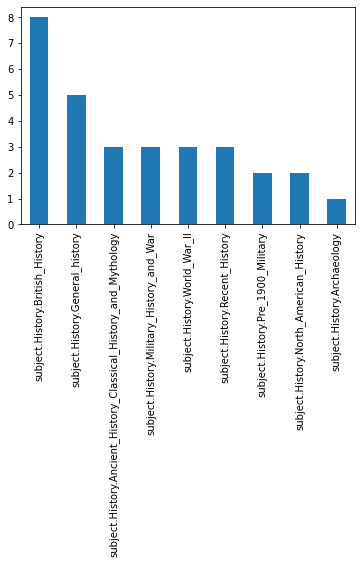

In [46]:
history30['category'].value_counts().plot(kind="bar")